<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Carteiras-Investimentos-Com-Rebalanceamentos/blob/main/Otimiza%C3%A7%C3%A3o_de_Carteiras_de_Investimentos_com_Rebalanceamentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install lifelines -U pymoo seaborn optuna pytesseract opencv-python

In [2]:
import numpy as np
import pandas as pd
import optuna
import requests
import seaborn as sns
import cv2
import pytesseract
import re
import lifelines
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from lifelines import KaplanMeierFitter
from lifelines import WeibullAFTFitter
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.moo.rnsga2 import RNSGA2
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.termination import get_termination
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.visualization.scatter import Scatter
from pymoo.core.problem import Problem
from pymoo.indicators.hv import HV
from google.colab.patches import cv2_imshow
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Token da API
token = 'wQsv3whghhynsSiXQj18Jm'
interval = '3mo'

In [4]:
df = pd.read_csv(f'/content/drive/MyDrive/datasets/dados-acoes/carteira-de-ativos.csv', sep=";")
df.head(3)

,Entrada/Saída,Data,Produto,Quantidade,Preço unitário,Valor da Operação
0,Compra,06/05/2024,CXSE3 - Caixa Seguridade,200,"R$16,14","R$3.228,00"
1,Venda,06/05/2024,CXSE3 - Caixa Seguridade,200,"R$15,67","R$3.134,00"
2,Venda,07/05/2024,PETR4 - Petroleo Brasileiro SA,200,"R$30,90","R$6.180,00"


In [5]:
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
df['Produto'] = df['Produto'].str.extract(r'(\w{4}\d)').squeeze()  # extrai CSAN3, KLBN4, etc.

# Extrai o ticker antes do ' - '
df['Ticker'] = df['Produto'].apply(lambda x: str(x).split(' - ')[0].strip())

# Evento: Compra = 1 (ativo entrou na carteira), Venda = 0 (saiu)
df['Evento'] = df['Entrada/Saída'].map({'Compra': 1, 'Venda': 0})

# Tempo: diferença entre a data da operação e uma referência (hoje ou última data da venda)
data_referencia = pd.to_datetime(datetime.today().date())  # data atual do sistema (a "data de hoje")
df['Tempo'] = (data_referencia - df['Data']).dt.days + 1  # +1 para evitar zero
df['Tempo'] = df['Tempo'].clip(lower=0.1).astype(float)  # Garante que 'Tempo' está positivo e em float

# Corrigir valores numéricos
df['Valor da Operação'] = df['Valor da Operação'].replace({'R\$': '', '\.': '', ',': '.'}, regex=True).astype(float)
df['Preço unitário'] = df['Preço unitário'].replace({'R\$': '', '\.': '', ',': '.'}, regex=True).astype(float)

# Agrupa por data e ticker e calcula preço médio (pode ser o unitário da compra/venda)
precos_historicos = df.groupby(['Data', 'Ticker'])['Preço unitário'].mean().unstack()

In [6]:
tempos_por_ticker = {}

for ticker, grupo in df.groupby('Ticker'):
    compras = grupo[grupo['Evento'] == 1].sort_values('Data')['Data'].tolist()
    vendas = grupo[grupo['Evento'] == 0].sort_values('Data')['Data'].tolist()

    pares = zip(compras, vendas)  # Emparelha na ordem
    tempos = [(venda - compra).days for compra, venda in pares if venda > compra]

    if tempos:
        tempos_por_ticker[ticker] = np.median(tempos)

# Resultado: dicionário {ticker: tempo_medio_em_dias}
tempo_medianos = tempos_por_ticker

In [7]:
df_surv = df[['Produto', 'Tempo', 'Evento']]
tickers = df['Ticker'].unique()

In [8]:
dados_ativos = []  # dicionário para guardar os dados vindos da https://brapi.dev

# Loop para consultar cada ticker
for ticker in tickers:
    url = f'https://brapi.dev/api/quote/{ticker}?range={interval}&interval=1d&fundamental=true&modules=summaryProfile&token={token}'
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        print(f"{ticker}: OK")
        result = data['results'][0]

        preco_atual = result.get('regularMarketPrice')
        # Calcular a média dos fechamentos com base no intervalo, em dias, configurado na url
        historico = result.get('historicalDataPrice', [])
        precos_fechamento = [dia.get('close') for dia in historico if dia.get('close') is not None]

        if precos_fechamento:
            media_dias = sum(precos_fechamento) / len(precos_fechamento)
            variacao_pct = (preco_atual - media_dias) / media_dias if preco_atual else None
        else:
            media_dias = None
            variacao_pct = None

        dados_ativos.append({
            'Ticker': ticker,
            'Empresa': result.get('shortName'),
            'Setor': result.get('summaryProfile', {}).get('sector'),
            'Preço Atual': preco_atual,
            'Média em Dias': media_dias,
            'Variação % Média em Dias': variacao_pct,
            'Min 52 Semanas': result.get('fiftyTwoWeekLow'),
            'Max 52 Semanas': result.get('fiftyTwoWeekHigh'),
            'P/L': result.get('fundamental', {}).get('peRatio'),
            'DY (%)': result.get('fundamental', {}).get('dividendYield'),
            'ROE (%)': result.get('fundamental', {}).get('returnOnEquity'),
            'P/VP': result.get('fundamental', {}).get('priceToBook'),
            'Volume Médio': result.get('averageDailyVolume3Month')
        })

    else:
        print(f"{ticker}: ERRO - {response.status_code}")

CXSE3: OK
PETR4: OK
VALE3: OK
BBAS3: OK


In [9]:
# Converter para DataFrame
df_api = pd.DataFrame(dados_ativos)
# Salvar em CSV
df_api.to_csv('/content/drive/MyDrive/datasets/dados-acoes/ativos_brapi.csv', index=False)
print("\n✅ Dados salvos em 'ativos_brapi.csv'.")


✅ Dados salvos em 'ativos_brapi.csv'.


In [10]:
df_api = pd.read_csv('/content/drive/MyDrive/datasets/dados-acoes/ativos_brapi.csv')
df_api.head(3)

,Ticker,Empresa,Setor,Preço Atual,Média em Dias,Variação % Média em Dias,Min 52 Semanas,Max 52 Semanas,P/L,DY (%),ROE (%),P/VP,Volume Médio
0,CXSE3,CAIXA SEGURION EDR NM,Financial Services,15.25,15.378305,-0.008343,13.42,16.83,NaN,NaN,NaN,NaN,NaN
1,PETR4,PETROBRAS PN N2,Energy,30.06,34.770339,-0.135470,29.66,42.09,NaN,NaN,NaN,NaN,NaN
2,VALE3,VALE ON NM,Basic Materials,52.74,55.176667,-0.044161,48.77,67.10,NaN,NaN,NaN,NaN,NaN


In [11]:
# # -------------------------------------------
# # 1. SIMULA - CALCULA FRAILTY BASEADO NA VARIAÇÃO
# # -------------------------------------------

# # Frailty com base na variação percentual da média em dias
# frailty_fatores = {}

# for dados in dados_ativos:
#     ticker = dados['Ticker']
#     variacao = dados.get('Variação % Média em Dias')
#     frailty_fatores[ticker] = round(1 + variacao, 2) if variacao is not None else 1.0

# # Aqui usamos apenas os tickers com dados válidos
# ativos = [dado['Ticker'] for dado in dados_ativos]

# # CALCULA MÉDIAS REAIS PARA CALIBRAR LAMBDA
# medias_por_ativo = df.groupby('Ticker')['Tempo'].mean().to_dict()

# # Geração dos dados de eventos COM AJUSTE POR ATIVO
# dados_eventos = []
# n = 100                 # Número de amostras por ativo
# beta_base = 2.0         # Forma da distribuição Weibull

# for ativo in ativos:
#     lambda_ajustada = medias_por_ativo.get(ativo, 30) / beta_base  # fallback: 30 dias médios e lambda representa a escala da distribuição Weibull
#     frailty = frailty_fatores.get(ativo, 1.0)

#     # Simula os tempos com distribuição Weibull calibrada
#     tempos = np.random.weibull(beta_base, n) * lambda_ajustada / frailty
#     eventos = np.random.binomial(1, 0.8, n)  # 80% chance de ocorrência de evento

#     for t, e in zip(tempos, eventos):
#         dados_eventos.append({
#             'Ativo': ativo,
#             'Tempo': round(t, 2),
#             'Evento': e,
#             'Frailty': frailty
#         })

# df_eventos = pd.DataFrame(dados_eventos)
# print(df_eventos.head())

In [12]:
# -------------------------------------------
# 1. CALCULA FRAILTY BASEADO NA VARIAÇÃO
# -------------------------------------------

# Frailty com base na variação percentual da média em dias
frailty_fatores = {}
for dados in dados_ativos:
    ticker = dados['Ticker']
    variacao = dados.get('Variação % Média em Dias')
    frailty_fatores[ticker] = round(1 + variacao, 2) if variacao is not None else 1.0

# Aqui usamos apenas os tickers com dados válidos
ativos = [dado['Ticker'] for dado in dados_ativos]

# Aplica a frailty no DataFrame real
df['Frailty'] = df['Ticker'].map(frailty_fatores).fillna(1.0)

# Cria o DataFrame final de eventos
df_eventos = df[['Ticker', 'Tempo', 'Evento', 'Frailty']].copy()
df_eventos = df_eventos.rename(columns={'Ticker': 'Ativo'})

# Visualiza os primeiros registros
print(df_eventos.head())

   Ativo  Tempo  Evento  Frailty
0  CXSE3  367.0       1     0.99
1  CXSE3  367.0       0     0.99
2  PETR4  366.0       0     0.86
3  CXSE3  365.0       1     0.99
4  VALE3  364.0       0     0.96


In [13]:
# -----------------------------
# 2. AJUSTE DO MODELO WEIBULL AFT COM FRAILTY VIA DUMMIES
# -----------------------------

df_model = pd.get_dummies(df_eventos[['Tempo', 'Evento', 'Ativo', 'Frailty']], columns=['Ativo'], drop_first=False)
aft = WeibullAFTFitter()
aft.fit(df_model, duration_col='Tempo', event_col='Evento')

/usr/local/lib/python3.11/dist-packages/lifelines/fitters/__init__.py:2097: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, exceptions.StatisticalWarning)


<lifelines.WeibullAFTFitter: fitted with 457 total observations, 238 right-censored observations>

O presente modelo de sobrevivência foi construído para estimar o tempo até a ocorrência de um evento de compra (entrada) de um ativo na carteira, utilizando o modelo *Weibull AFT (Accelerated Failure Time*) com ajuste de *frailty* para capturar heterogeneidades entre os ativos. No contexto deste estudo, o evento binário é definido como "**Compra**" (1), representando a entrada do ativo na carteira, enquanto "**Venda**" (0) indica que o evento ainda não ocorreu (censura). Dessa forma, as curvas de sobrevivência estimadas representam a probabilidade de o ativo ainda não ter sido comprado conforme o tempo passa. Ativos com curvas que decaem mais rapidamente indicam maior propensão a serem comprados em menor tempo — ou seja, com maior probabilidade de participação ativa na carteira ao longo do tempo. Considerando a natureza cíclica das operações (compra e venda), este processo também pode ser interpretado como **uma modelagem do tempo até o próximo rebalanciamento do ativo na carteira**.


* Quando a curva cai abaixo de 0.5, significa que mais da metade dos casos já sofreram o evento.

* O ponto em que a curva cruza 0.5 é chamado de tempo mediano de sobrevivência.

Ele é útil para comparar ativos: quanto maior esse tempo, mais tempo o ativo costuma permanecer na carteira sem ser rebalanceado.

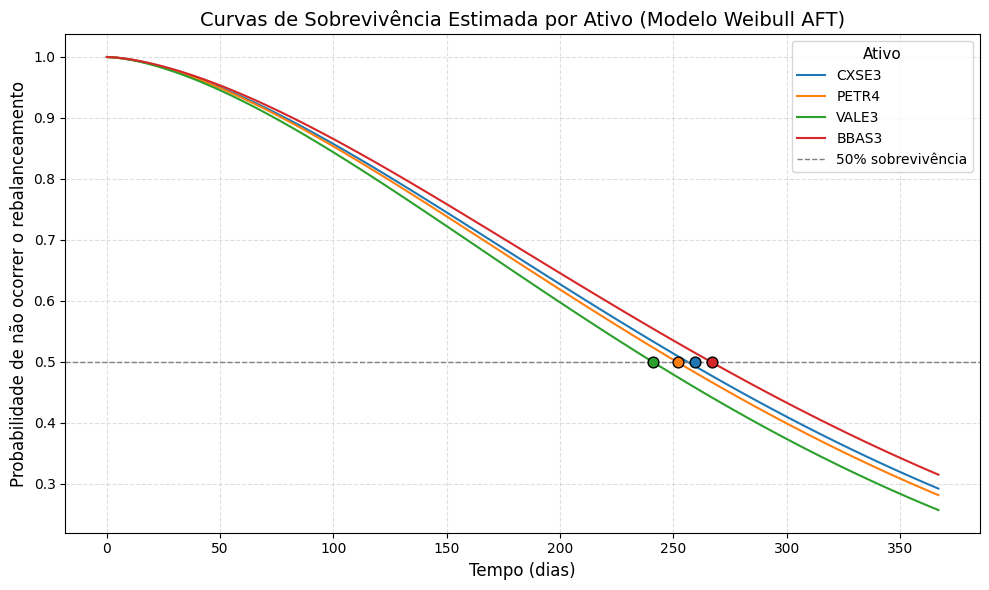

In [14]:
# -----------------------------------
# 3. PLOTAR CURVAS DE SOBREVIVÊNCIA
# ----------------------------------
# Cria figura e eixos
fig, ax = plt.subplots(figsize=(10, 6))

# Paleta de cores para distinguir os ativos
cores = sns.color_palette("tab10", n_colors=len(ativos))

# Plota curvas de sobrevivência por ativo
for i, ativo in enumerate(ativos):
    # Cria amostra com zeros e ativa a dummy correspondente (se existir)
    amostra = pd.DataFrame([0] * (len(df_model.columns) - 2), index=df_model.columns.drop(['Tempo', 'Evento'])).T
    col_dummy = f'Ativo_{ativo}'
    if col_dummy in amostra.columns:
        amostra[col_dummy] = 1

    # Gera curva de sobrevivência para o ativo
    surv_func = aft.predict_survival_function(amostra, times=np.linspace(0.1, df_eventos['Tempo'].max(), 100))

    # Plota curva
    ax.plot(surv_func.index, surv_func.values.flatten(), label=ativo, color=cores[i])

    # Marca a mediana de sobrevivência (tempo onde a curva cruza 0.5)
    y = surv_func.values.flatten()
    x = surv_func.index
    cruzamento = np.where(y <= 0.5)[0]
    if cruzamento.any():
        tempo_mediano = x[cruzamento[0]]
        ax.scatter(tempo_mediano, 0.5, color=cores[i], s=60, marker='o', edgecolor='black', zorder=5)

# Linha horizontal indicando 50% de sobrevivência
ax.axhline(0.5, color='gray', linestyle='--', linewidth=1, label='50% sobrevivência')

# Títulos e rótulos
ax.set_title('Curvas de Sobrevivência Estimada por Ativo (Modelo Weibull AFT)', fontsize=14)
ax.set_xlabel('Tempo (dias)', fontsize=12)
ax.set_ylabel('Probabilidade de não ocorrer o rebalanceamento', fontsize=12)

# Legenda lateral
ax.legend(title="Ativo", fontsize=10, title_fontsize=11)

# Estética
ax.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

Nesse ponto tentamos responder à seguinte pergunta:

***“Qual seria a melhor alocação percentual nos ativos para maximizar retorno, minimizar risco e evitar rebalanceamentos caros?”***

A função funcao_objetivo(trial) tenta encontrar os melhores pesos (porcentagens de alocação) para cada ativo da lista ativos. Ela considera 3 fatores:

* Retorno esperado (simulado aleatoriamente entre 5% e 25% por ativo).

* Risco (calculado de forma genérica usando norma dos pesos).

* Custo de rebalanceamento (penaliza mudanças nos pesos em relação a um valor-alvo de 10%).

Depois disso, o Optuna testa várias combinações de pesos (100 no seu caso) para encontrar a melhor carteira, maximizando o retorno e minimizando o risco e custo de rebalanceamento.

In [15]:
#--------------------------------------------------------------------------
# PRÉ-CÁLCULOS PARA A FUNÇÃO NA 4 ETAPA DE OTIMIZAÇÃO BAYESIANA COM OPTUNA
#--------------------------------------------------------------------------
retornos_diarios = precos_historicos.pct_change().dropna() # calcule os retornos diários
retornos_ativos = retornos_diarios.mean().to_dict()  # retorno médio por ativo
riscos_ativos = retornos_diarios.std().to_dict()     # desvio padrão por ativo (risco)

<ipython-input-15-8e2862a0cef7>:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  retornos_diarios = precos_historicos.pct_change().dropna() # calcule os retornos diários


Este trecho de código realiza a otimização dos pesos dos ativos da carteira utilizando a técnica de Otimização Bayesiana com a biblioteca Optuna. O objetivo principal é encontrar a alocação ideal dos ativos — ou seja, os percentuais que cada ativo deve representar na carteira — de forma que o retorno esperado seja maximizado, enquanto o risco total e os custos de rebalanceamento sejam minimizados.

Primeiramente, são calculados os retornos e riscos reais de cada ativo com base nos preços históricos: o retorno é obtido pela média dos retornos diários e o risco pelo desvio padrão desses retornos. Também é utilizado o tempo mediano de permanência de cada ativo na carteira (calculado anteriormente) como uma forma de penalizar ativos que exigem rebalanceamento muito frequente.

A função objetivo da otimização recebe os pesos sugeridos para os ativos, normaliza esses pesos, e então calcula:

o retorno esperado da carteira (média ponderada dos retornos),

o risco total da carteira (média ponderada dos desvios padrão),

e um custo de rebalanceamento proporcional à frequência com que os ativos são comprados ou vendidos.

Esses três fatores são combinados em uma métrica única chamada "score", que é o valor a ser minimizado durante o processo de otimização. Ao final, o Optuna retorna a melhor combinação de pesos encontrada, representando a composição ótima da carteira segundo os critérios definidos.

In [16]:
# -----------------------------------
# 4. OTIMIZAÇÃO BAYESIANA COM OPTUNA
# -----------------------------------

def funcao_objetivo(trial):
    peso_ativos = np.array([trial.suggest_float(f"peso_{i}", 0.0, 1.0) for i in range(len(ativos))])
    peso_ativos /= peso_ativos.sum()

    retornos = np.array([retornos_ativos.get(ativo, 0.0) for ativo in ativos])
    riscos = np.array([riscos_ativos.get(ativo, 0.1) for ativo in ativos])
    rebal_freq = np.array([1 / tempo_medianos.get(ativo, 30.0) for ativo in ativos])

    retorno_esperado = np.dot(peso_ativos, retornos)
    risco_total = np.dot(peso_ativos, riscos)
    custo_rebalanceamento = np.dot(peso_ativos, rebal_freq) * 0.01

    score = retorno_esperado - risco_total - custo_rebalanceamento
    return -score

study = optuna.create_study(direction="minimize")
study.optimize(funcao_objetivo, n_trials=100)

print("\nMelhores pesos encontrados pela Otimização Bayesiana (Optuna):")
for i, ativo in enumerate(ativos):
    print(f"{ativo}: {study.best_params[f'peso_{i}']:.4f}")
print("Score final:", -study.best_value)

[I 2025-05-07 19:43:37,889] A new study created in memory with name: no-name-aa4a3a6e-e5d6-469f-ab77-a8540ee4cb92
[I 2025-05-07 19:43:37,895] Trial 0 finished with value: 0.06580267924058535 and parameters: {'peso_0': 0.2792491002353361, 'peso_1': 0.9901751086339662, 'peso_2': 0.6414887135547209, 'peso_3': 0.4641770495656471}. Best is trial 0 with value: 0.06580267924058535.
[I 2025-05-07 19:43:37,898] Trial 1 finished with value: 0.057351754569249354 and parameters: {'peso_0': 0.228346519995281, 'peso_1': 0.27165855122543614, 'peso_2': 0.1482379011467584, 'peso_3': 0.8684309200171808}. Best is trial 1 with value: 0.057351754569249354.
[I 2025-05-07 19:43:37,906] Trial 2 finished with value: 0.05786727307256914 and parameters: {'peso_0': 0.9148979811752224, 'peso_1': 0.5085620697474884, 'peso_2': 0.7849260685579365, 'peso_3': 0.5186834903564865}. Best is trial 1 with value: 0.057351754569249354.
[I 2025-05-07 19:43:37,909] Trial 3 finished with value: 0.05824962315584843 and parameters


Melhores pesos encontrados pela Otimização Bayesiana (Optuna):
CXSE3: 0.8732
PETR4: 0.0168
VALE3: 0.0316
BBAS3: 0.3005
Score final: -0.04270775988652418


In [17]:
# Converte os dicionários para arrays na mesma ordem de 'ativos'
retorno_ativos_array = np.array([retornos_ativos[ativo] for ativo in ativos])
risco_ativos_array = np.array([riscos_ativos[ativo] for ativo in ativos])
rebal_freq_array = np.array([1 / tempo_medianos[ativo] for ativo in ativos])  # frequência ≈ 1 / tempo mediano

In [18]:
# -----------------------------
# 5. OTIMIZAÇÃO MULTIOBJETIVO COM NSGA-II E MOPSO (via pymoo)
# -----------------------------

# Define o problema de otimização multiobjetivo
class CarteiraMultiObjetivo(Problem):
    def __init__(self):
        super().__init__(
            n_var=len(ativos),   # número de ativos
            n_obj=3,             # retorno, risco e custo
            n_constr=1,          # soma dos pesos = 1
            xl=0.0,              # limite inferior dos pesos
            xu=1.0               # limite superior dos pesos
        )

    def _evaluate(self, x, out, *args, **kwargs):
        x = np.array(x)

        # Calcula os 3 objetivos
        retorno = np.sum(x * retorno_ativos_array, axis=1)
        risco = np.sum(x * risco_ativos_array, axis=1)
        custo = np.sum(x * rebal_freq_array, axis=1) * 0.01  # penalidade por frequência de rebalanceamento

        # Define objetivos (lembrando: pymoo minimiza → -retorno para maximizar)
        out["F"] = np.column_stack([-retorno, risco, custo])

        # Restrição: soma dos pesos deve ser 1
        out["G"] = np.sum(x, axis=1) - 1

problem = CarteiraMultiObjetivo()

In [19]:
termination = get_termination("n_gen", 100)

In [20]:
# -----------------------------
# Configurar algoritmo NSGA-II
# -----------------------------
algorithm_nsga2 = NSGA2(
    pop_size=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

# -----------------------------
# Executar otimização
# -----------------------------
res_nsga2 = minimize(
    problem,
    algorithm_nsga2,
    termination,
    seed=1,
    save_history=True,
    verbose=False
)

**📊 Resumo do gráfico de convergência (Hypervolume)**

Este gráfico mostra a evolução da qualidade da fronteira de soluções (HV - Hypervolume) ao longo das gerações do algoritmo NSGA-II. O valor do HV indica o quão bem distribuídas e otimizadas estão as soluções no espaço de objetivos.

* Cada ponto representa o HV de uma geração.

* A linha tracejada vermelha indica a geração em que surgiu a solução mais balanceada, ou seja, a que apresenta o melhor equilíbrio entre retorno, risco e custo.

* A anotação exibe os valores dos objetivos dessa solução e a geração correspondente.

* O eixo Y foi renomeado para "Qualidade da Fronteira (HV)" para facilitar a interpretação.

Este gráfico é útil para entender quando e como o algoritmo encontrou soluções eficientes e balanceadas.

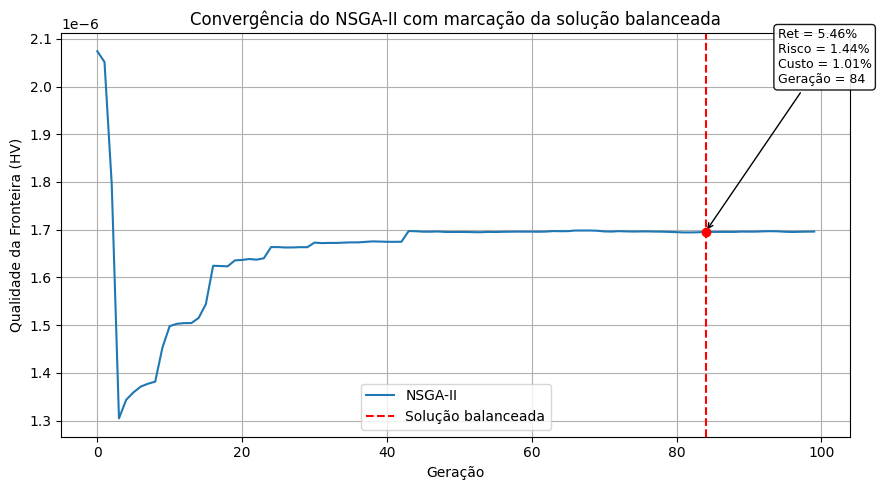

In [53]:
# -----------------------------
# Calcular HV por geração
# -----------------------------

all_F = np.vstack([gen.pop.get("F") for gen in res_nsga2.history])
ref_point = np.max(all_F, axis=0) * 1.1  # ponto de referência 10% acima do pior valor em cada objetivo

hv = HV(ref_point=ref_point)
hv_values = []

for algo_gen in res_nsga2.history:
    F = algo_gen.pop.get("F")
    hv_values.append(hv.do(F))

# -----------------------------
# Encontrar solução mais balanceada (mínima soma de ranks)
# -----------------------------

pareto_objectives = res_nsga2.F  # [ -retorno, risco, custo ]

# Rank normalizado para cada objetivo
rankings = np.argsort(np.argsort(pareto_objectives, axis=0), axis=0)
rank_sums = np.sum(rankings, axis=1)
melhor_idx = np.argmin(rank_sums)

melhor_obj = pareto_objectives[melhor_idx]

# Localizar em qual geração essa solução apareceu
geracao_melhor_balanceada = None
for gen_idx, gen in enumerate(res_nsga2.history):
    F_gen = gen.pop.get("F")
    for f in F_gen:
        if np.allclose(f, melhor_obj):
            geracao_melhor_balanceada = gen_idx
            break
    if geracao_melhor_balanceada is not None:
        break

# -----------------------------
# Plotar gráfico final
# -----------------------------

plt.figure(figsize=(9, 5))
plt.plot(np.arange(len(hv_values)), hv_values, label='NSGA-II')

# Marcar apenas a geração da solução balanceada
if geracao_melhor_balanceada is not None:
    plt.axvline(x=geracao_melhor_balanceada, color='red', linestyle='--', label='Solução balanceada')
    plt.scatter(geracao_melhor_balanceada, hv_values[geracao_melhor_balanceada], color='red', zorder=5)

    # Ponto de anotação (canto superior direito)
    x_text = plt.xlim()[1] - 10
    y_text = plt.ylim()[1] * 0.95

    # Adicionar anotação com seta
    plt.annotate(
        f'Ret = {-melhor_obj[0] * 10000000:.2f}%\nRisco = {melhor_obj[1] * 100000:.2f}%\nCusto = {melhor_obj[2] * 10000000:.2f}%\nGeração = {geracao_melhor_balanceada}',
        xy=(geracao_melhor_balanceada, hv_values[geracao_melhor_balanceada]),  # ponto da seta
        xytext=(x_text, y_text),  # posição do texto
        arrowprops=dict(arrowstyle='->'),
        fontsize=9,
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.9)
    )

# Título e legendas
plt.title("Convergência do NSGA-II com marcação da solução balanceada")
plt.xlabel("Geração")
plt.ylabel("Qualidade da Fronteira (HV)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
print("Retorno", -melhor_obj[0])
print("Risco", melhor_obj[1])
print("Custo", melhor_obj[2])

Retorno 5.457268373273603e-07
Risco 1.4379585422460616e-05
Custo 1.013221638774957e-07


In [23]:
# -------------------------------------
# NSGA-III
# -------------------------------------
ref_dirs_nsga3 = get_reference_directions("das-dennis", 3, n_partitions=12)
algorithm_nsga3 = NSGA3(
    ref_dirs=ref_dirs_nsga3,
    pop_size=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

res_nsga3 = minimize(problem,
                     algorithm_nsga3,
                     termination,
                     seed=1,
                     save_history=True,
                     verbose=True)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      5 |  0.000000E+00 |  1.0491584576 |             - |             -
     2 |      200 |      9 |  0.000000E+00 |  0.4087232731 |  0.2503102783 |         ideal
     3 |      300 |     13 |  0.000000E+00 |  0.0851940068 |  0.2622437757 |         ideal
     4 |      400 |     16 |  0.000000E+00 |  0.000000E+00 |  0.2079636186 |         ideal
     5 |      500 |     21 |  0.000000E+00 |  0.000000E+00 |  0.1341030443 |         ideal
     6 |      600 |     25 |  0.000000E+00 |  0.000000E+00 |  0.0732380021 |         ideal
     7 |      700 |     30 |  0.000000E+00 |  0.000000E+00 |  0.0431781480 |         ideal
     8 |      800 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0054415253 |         ideal
     9 |      900 |     28 |  0.000000E+00 |  0.000000E+00 |  0.0054120754 |         ideal
    10 |     1000 |     30 |  0.000000E+00 |  0.000000E+00 |  0.0164809114 |         ideal

In [24]:
# -------------------------------------
# R-NSGA-II
# -------------------------------------
ref_points = np.array([[0.1], [-0.9], [0.05]]) # ponto de aspiração fictício, pode ajustar
algorithm_rnsga2 = RNSGA2(
    ref_points=ref_points,
    pop_size=100,
    epsilon=0.01,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

res_rnsga2 = minimize(problem,
                      algorithm_rnsga2,
                      termination,
                      seed=1,
                      save_history=True,
                      verbose=True)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      5 |  0.000000E+00 |  1.0491584576 |             - |             -
     2 |      200 |     11 |  0.000000E+00 |  0.4087232731 |  0.2503102783 |         ideal
     3 |      300 |     23 |  0.000000E+00 |  0.0714970090 |  0.2921049689 |         ideal
     4 |      400 |     40 |  0.000000E+00 |  0.000000E+00 |  0.1600447957 |         ideal
     5 |      500 |     55 |  0.000000E+00 |  0.000000E+00 |  0.0200968435 |             f
     6 |      600 |     69 |  0.000000E+00 |  0.000000E+00 |  0.0770804579 |         ideal
     7 |      700 |     88 |  0.000000E+00 |  0.000000E+00 |  0.0117877315 |         ideal
     8 |      800 |     97 |  0.000000E+00 |  0.000000E+00 |  0.0093211325 |         ideal
     9 |      900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0677430777 |         ideal
    10 |     1000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.2800683904 |         nadir

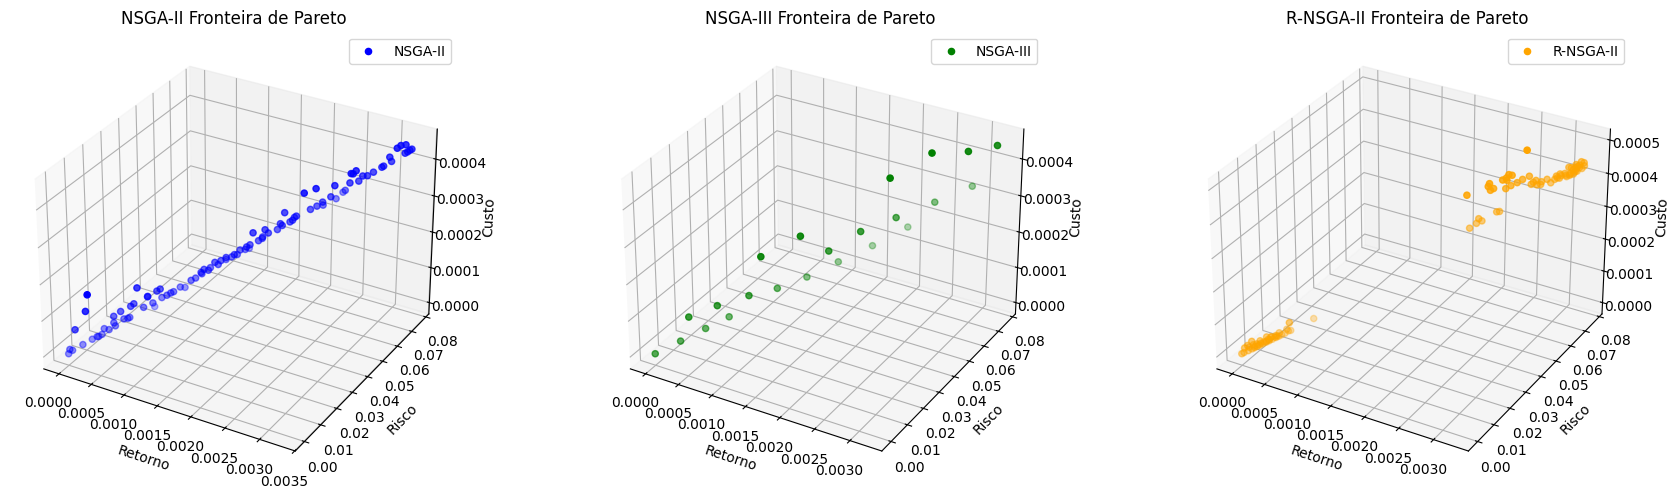

In [25]:
# -----------------------------
# 6. PLOTAR FRONTEIRA DE PARETO
# -----------------------------

fig = plt.figure(figsize=(18, 5))

# NSGA-II
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(-res_nsga2.F[:, 0], res_nsga2.F[:, 1], res_nsga2.F[:, 2], c='blue', label='NSGA-II')
ax1.set_title('NSGA-II Fronteira de Pareto')
ax1.set_xlabel('Retorno')
ax1.set_ylabel('Risco')
ax1.set_zlabel('Custo')
ax1.legend()

# NSGA-III
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(-res_nsga3.F[:, 0], res_nsga3.F[:, 1], res_nsga3.F[:, 2], c='green', label='NSGA-III')
ax2.set_title('NSGA-III Fronteira de Pareto')
ax2.set_xlabel('Retorno')
ax2.set_ylabel('Risco')
ax2.set_zlabel('Custo')
ax2.legend()

# R-NSGA-II
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(-res_rnsga2.F[:, 0], res_rnsga2.F[:, 1], res_rnsga2.F[:, 2], c='orange', label='R-NSGA-II')
ax3.set_title('R-NSGA-II Fronteira de Pareto')
ax3.set_xlabel('Retorno')
ax3.set_ylabel('Risco')
ax3.set_zlabel('Custo')
ax3.legend()

plt.tight_layout()
plt.show()